In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8), dpi=200)

In [3]:
df = pd.read_csv('136674-regression.txt', sep='\t')
X = df.drop(columns='class').values
y = df['class'].values
print(X.shape, y.shape)

(443, 125) (443,)


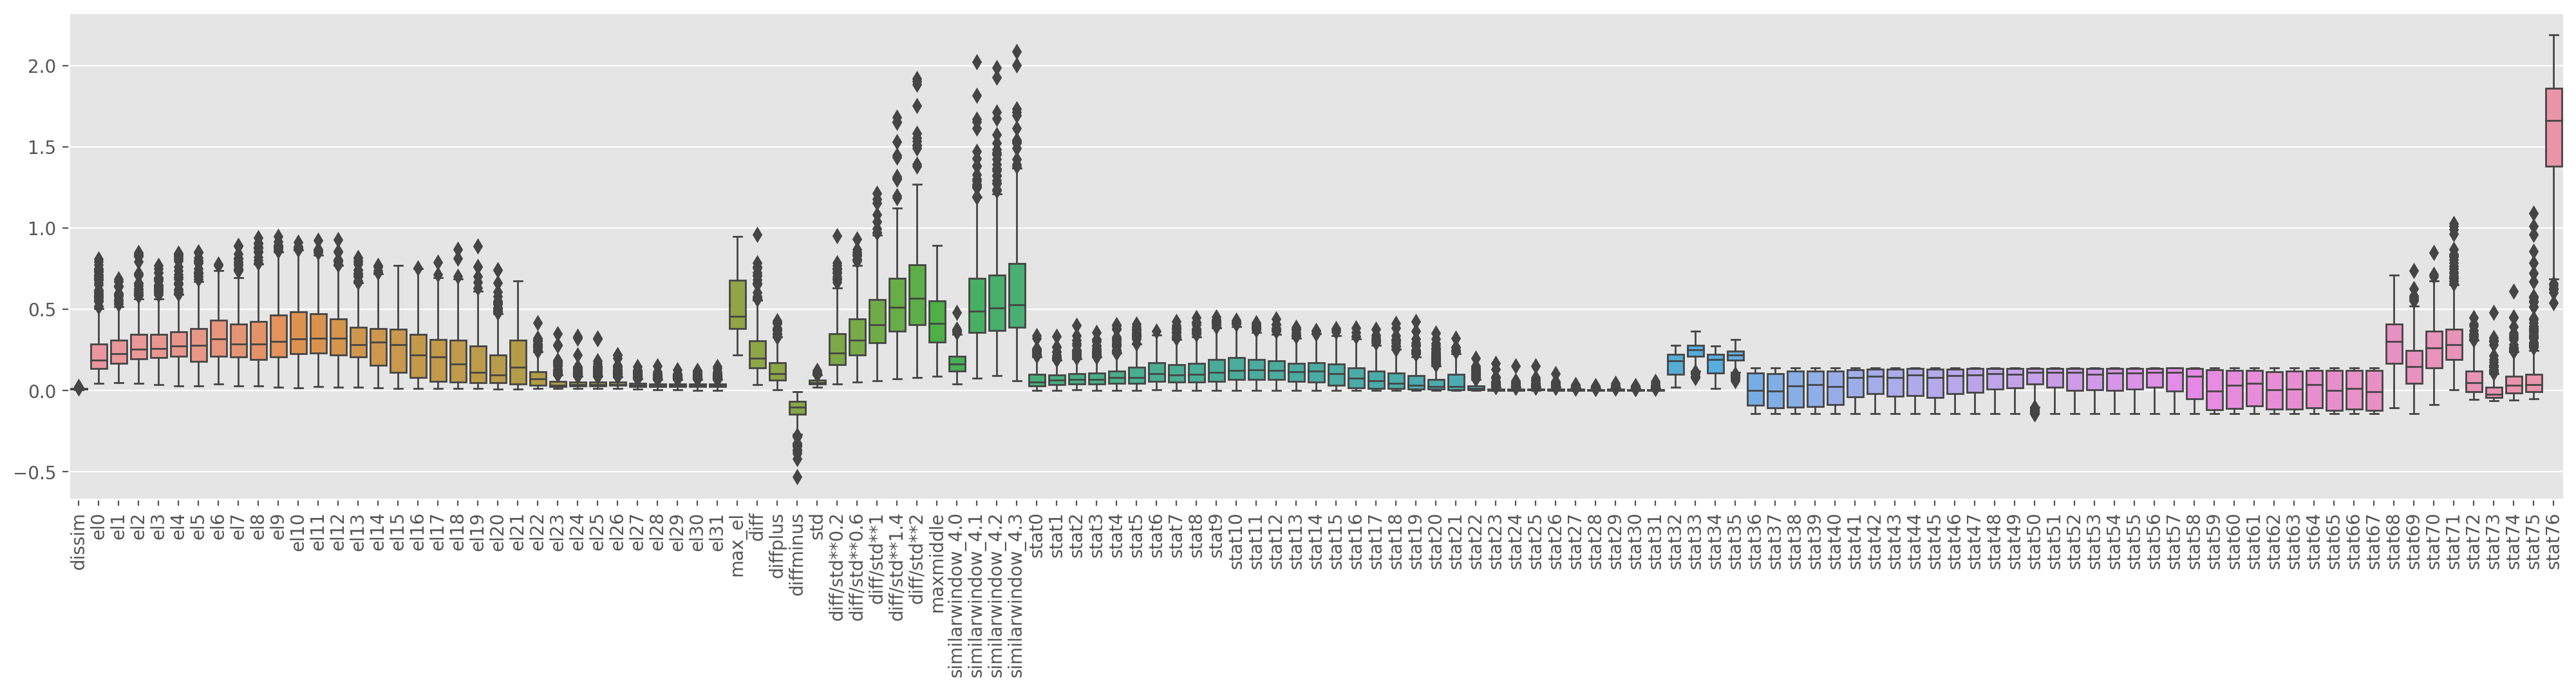

In [4]:
plt.subplots(figsize=(25, 5))
sns.boxplot(data=df.drop(columns='class'))
plt.xticks(rotation=90)
plt.show()

/home/max/.local/opt/miniconda3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='class', ylabel='Density'>

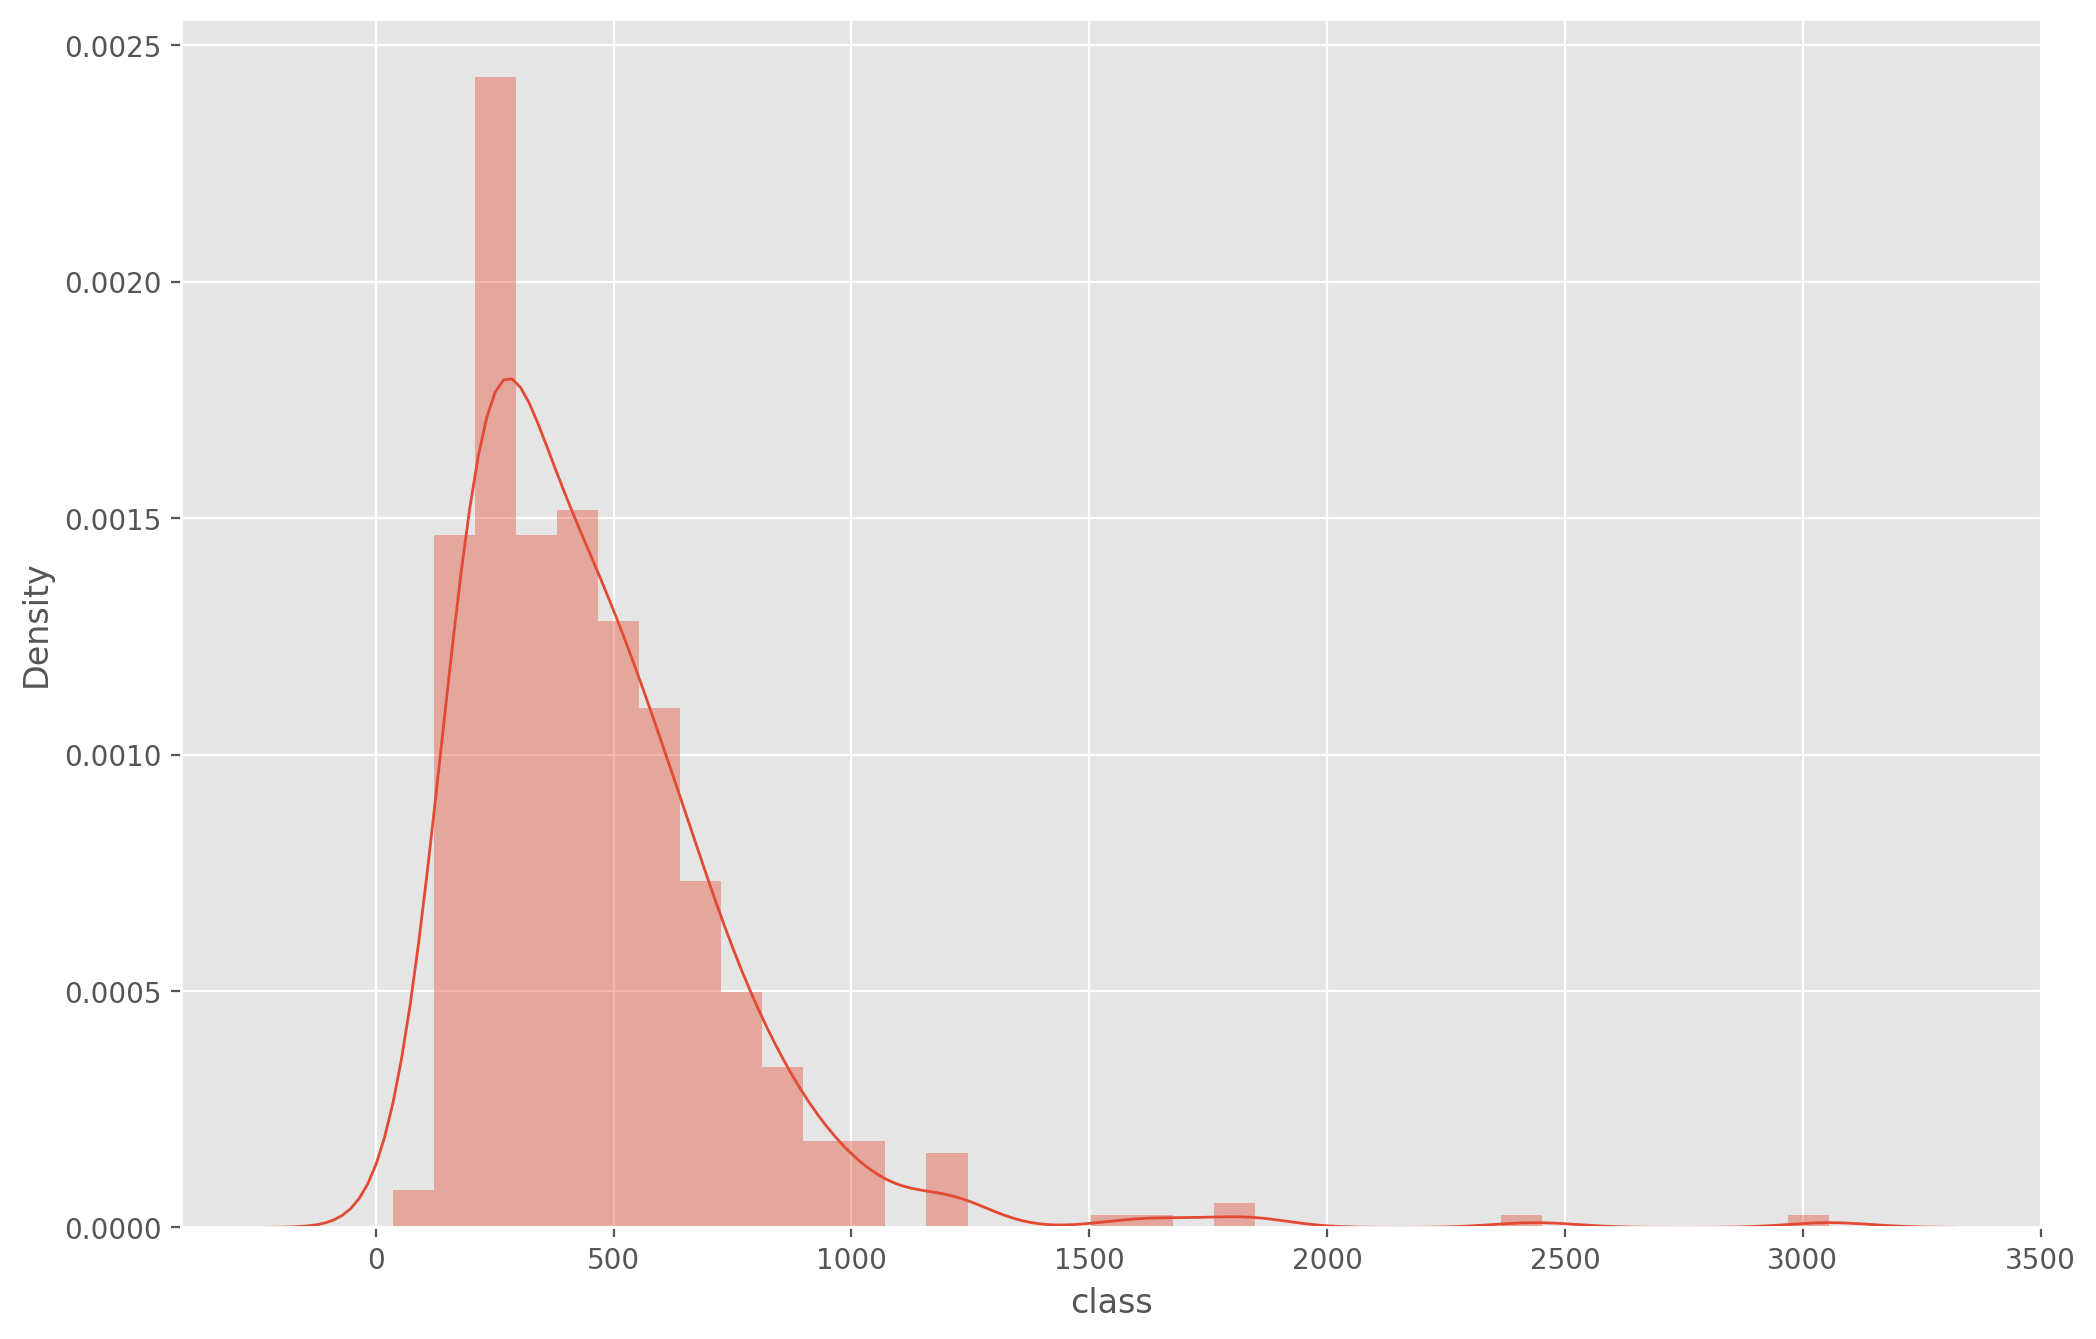

In [5]:
sns.distplot(df['class'])

In [6]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error as MAE, median_absolute_error as MedAE

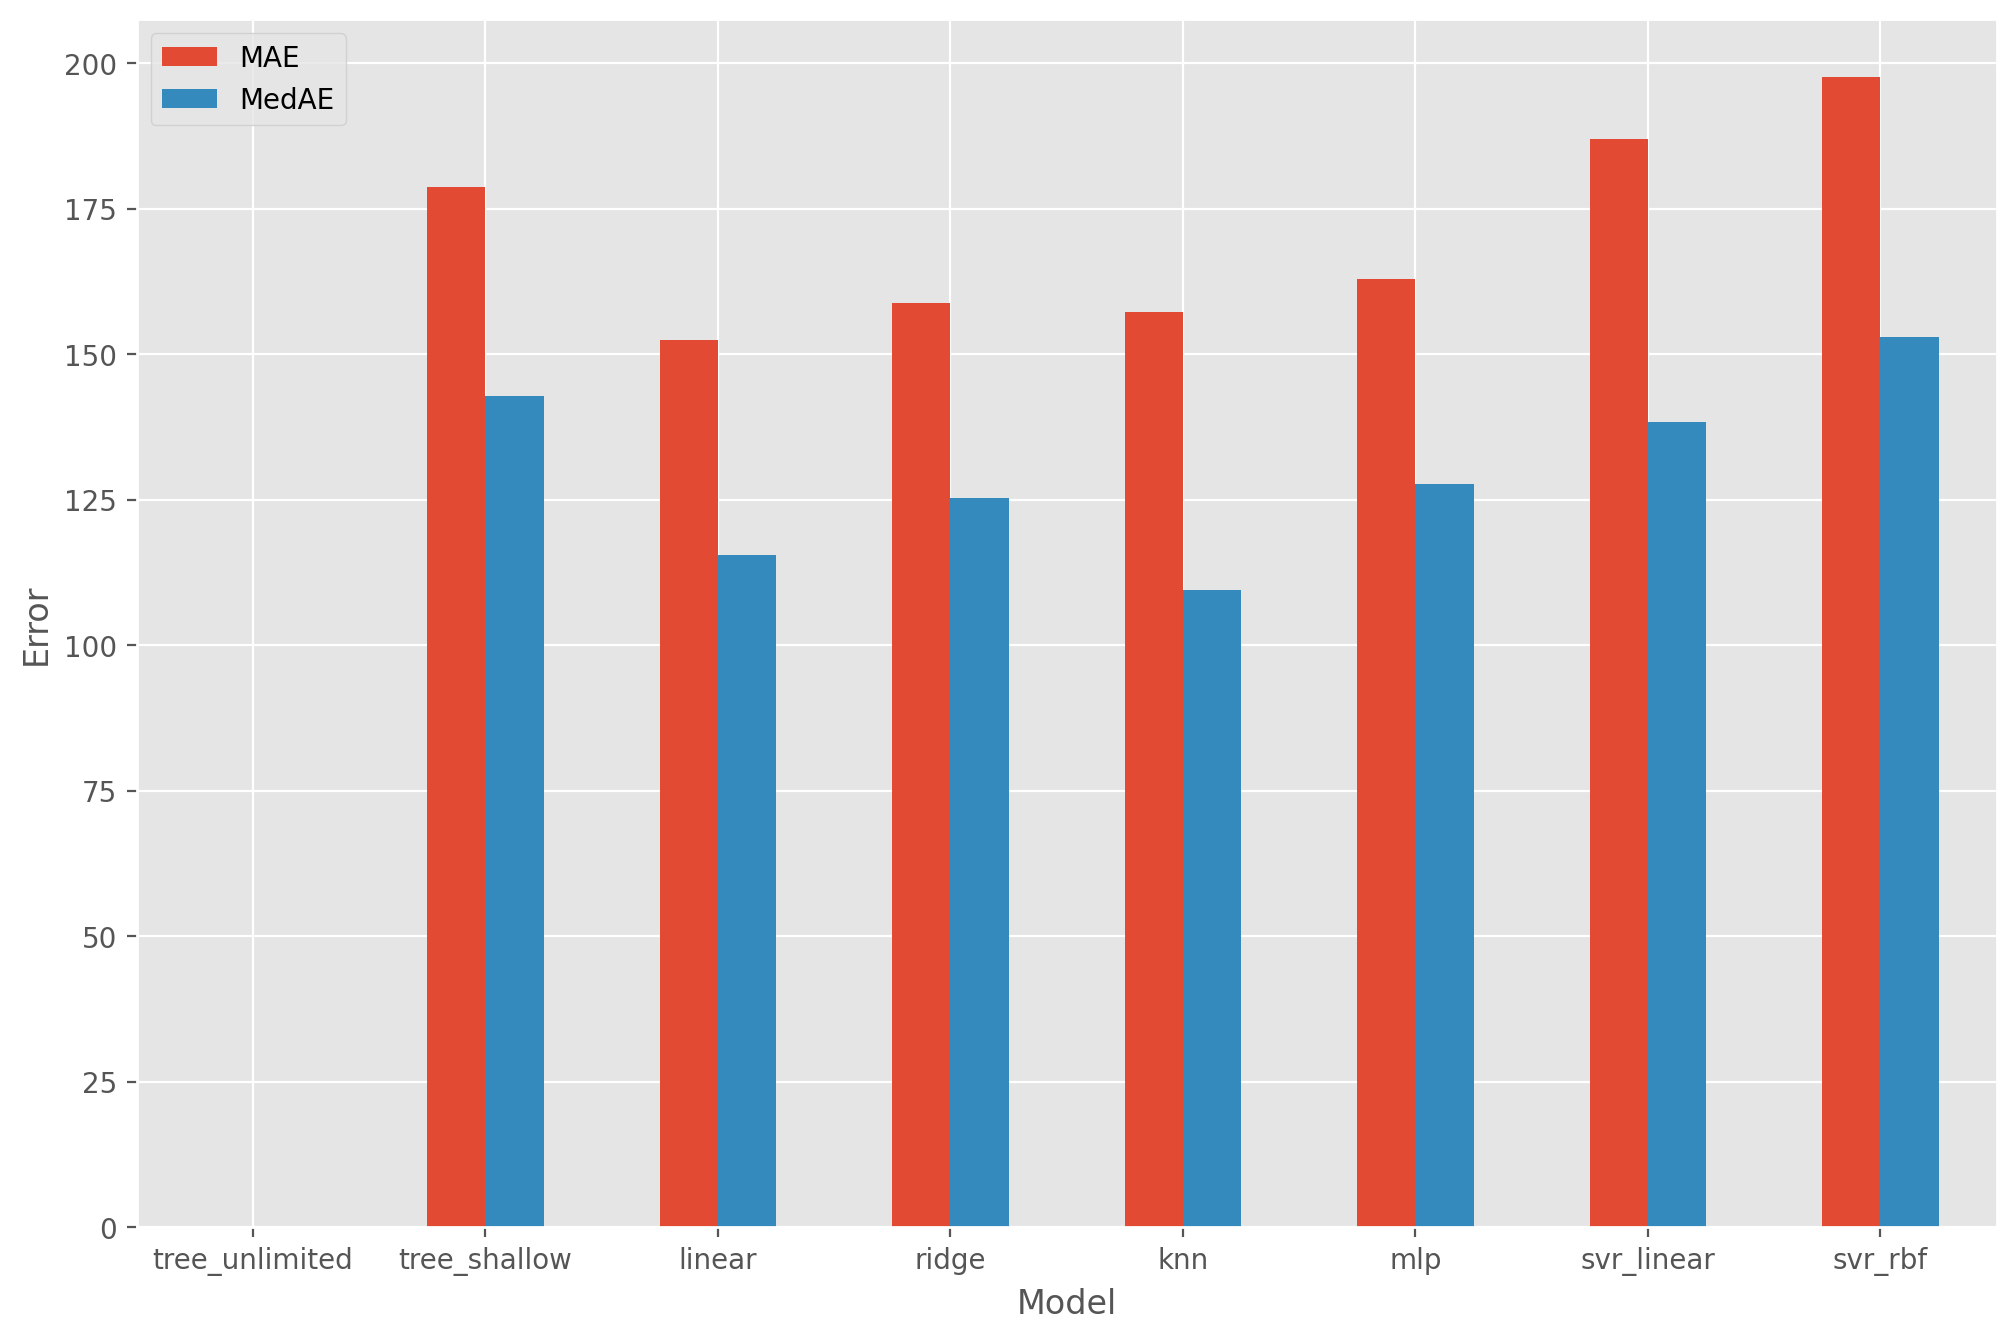

In [7]:
metrics = dict(MAE=MAE, MedAE=MedAE)
hidden = (100,)
iters = 10_000

models = dict(
    tree_unlimited=DecisionTreeRegressor(max_depth=None),
    tree_shallow=DecisionTreeRegressor(max_depth=2),
    linear=LinearRegression(normalize=False),
    ridge=Ridge(),
    knn=KNeighborsRegressor(),
    mlp=MLPRegressor(hidden_layer_sizes=hidden, max_iter=iters),
    svr_linear=SVR(kernel='linear'),
    svr_rbf=SVR(kernel='rbf'),
)

res = []
for model_name, model in models.items():
    model.fit(X, y)
    Y = model.predict(X)
    res.append(dict(Model=model_name, MAE=MAE(Y, y), MedAE=MedAE(Y, y)))
res = pd.DataFrame(res)
res

res.plot.bar(x='Model')
plt.xticks(rotation=0)
plt.ylabel('Error')
plt.show()

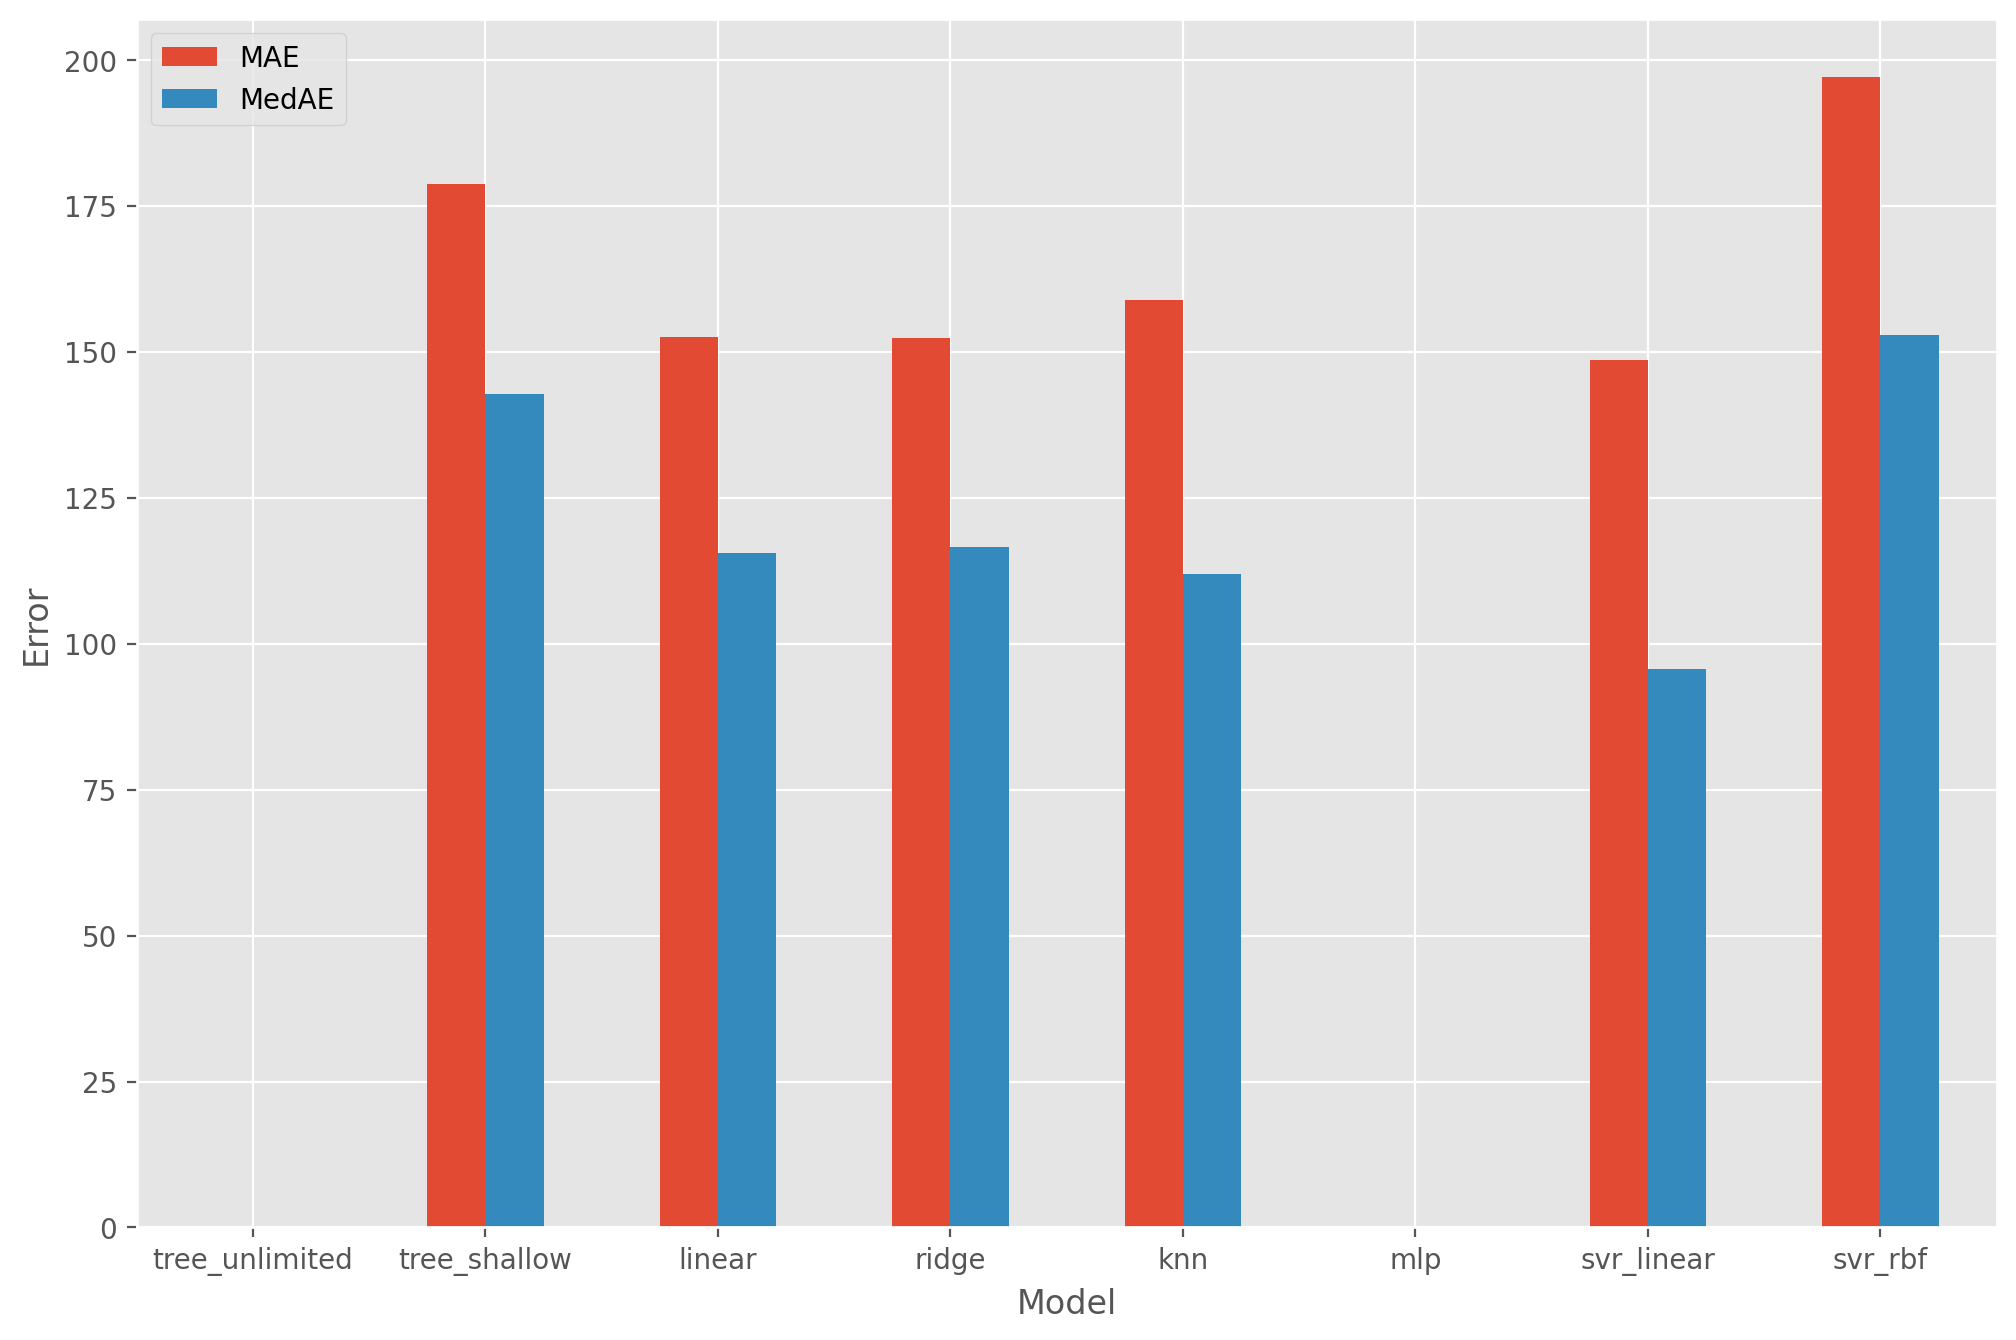

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

models = dict(
    tree_unlimited=DecisionTreeRegressor(max_depth=None),
    tree_shallow=DecisionTreeRegressor(max_depth=2),
    linear=make_pipeline(StandardScaler(), LinearRegression()),
    ridge=make_pipeline(StandardScaler(), Ridge()),
    knn=make_pipeline(StandardScaler(), KNeighborsRegressor()),
    mlp=make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden, max_iter=iters)),
    svr_linear=make_pipeline(StandardScaler(), SVR(kernel='linear')),
    svr_rbf=make_pipeline(StandardScaler(), SVR(kernel='rbf')),
)

res = []
for model_name, model in models.items():
    model.fit(X, y)
    Y = model.predict(X)
    res.append(dict(Model=model_name, MAE=MAE(Y, y), MedAE=MedAE(Y, y)))
res_total = pd.DataFrame(res)

res_total.plot.bar(x='Model')
plt.title('')
plt.xticks(rotation=0)
plt.ylabel('Error')
plt.show()

In [10]:
res_total

,Model,MAE,MedAE
0,tree_unlimited,0.000000,0.000000
1,tree_shallow,178.798516,142.756061
2,linear,152.509781,115.574782
3,ridge,152.405719,116.570669
4,knn,158.959368,112.000000
5,mlp,0.037446,0.025483
6,svr_linear,148.619941,95.692927
7,svr_rbf,197.087230,152.941455


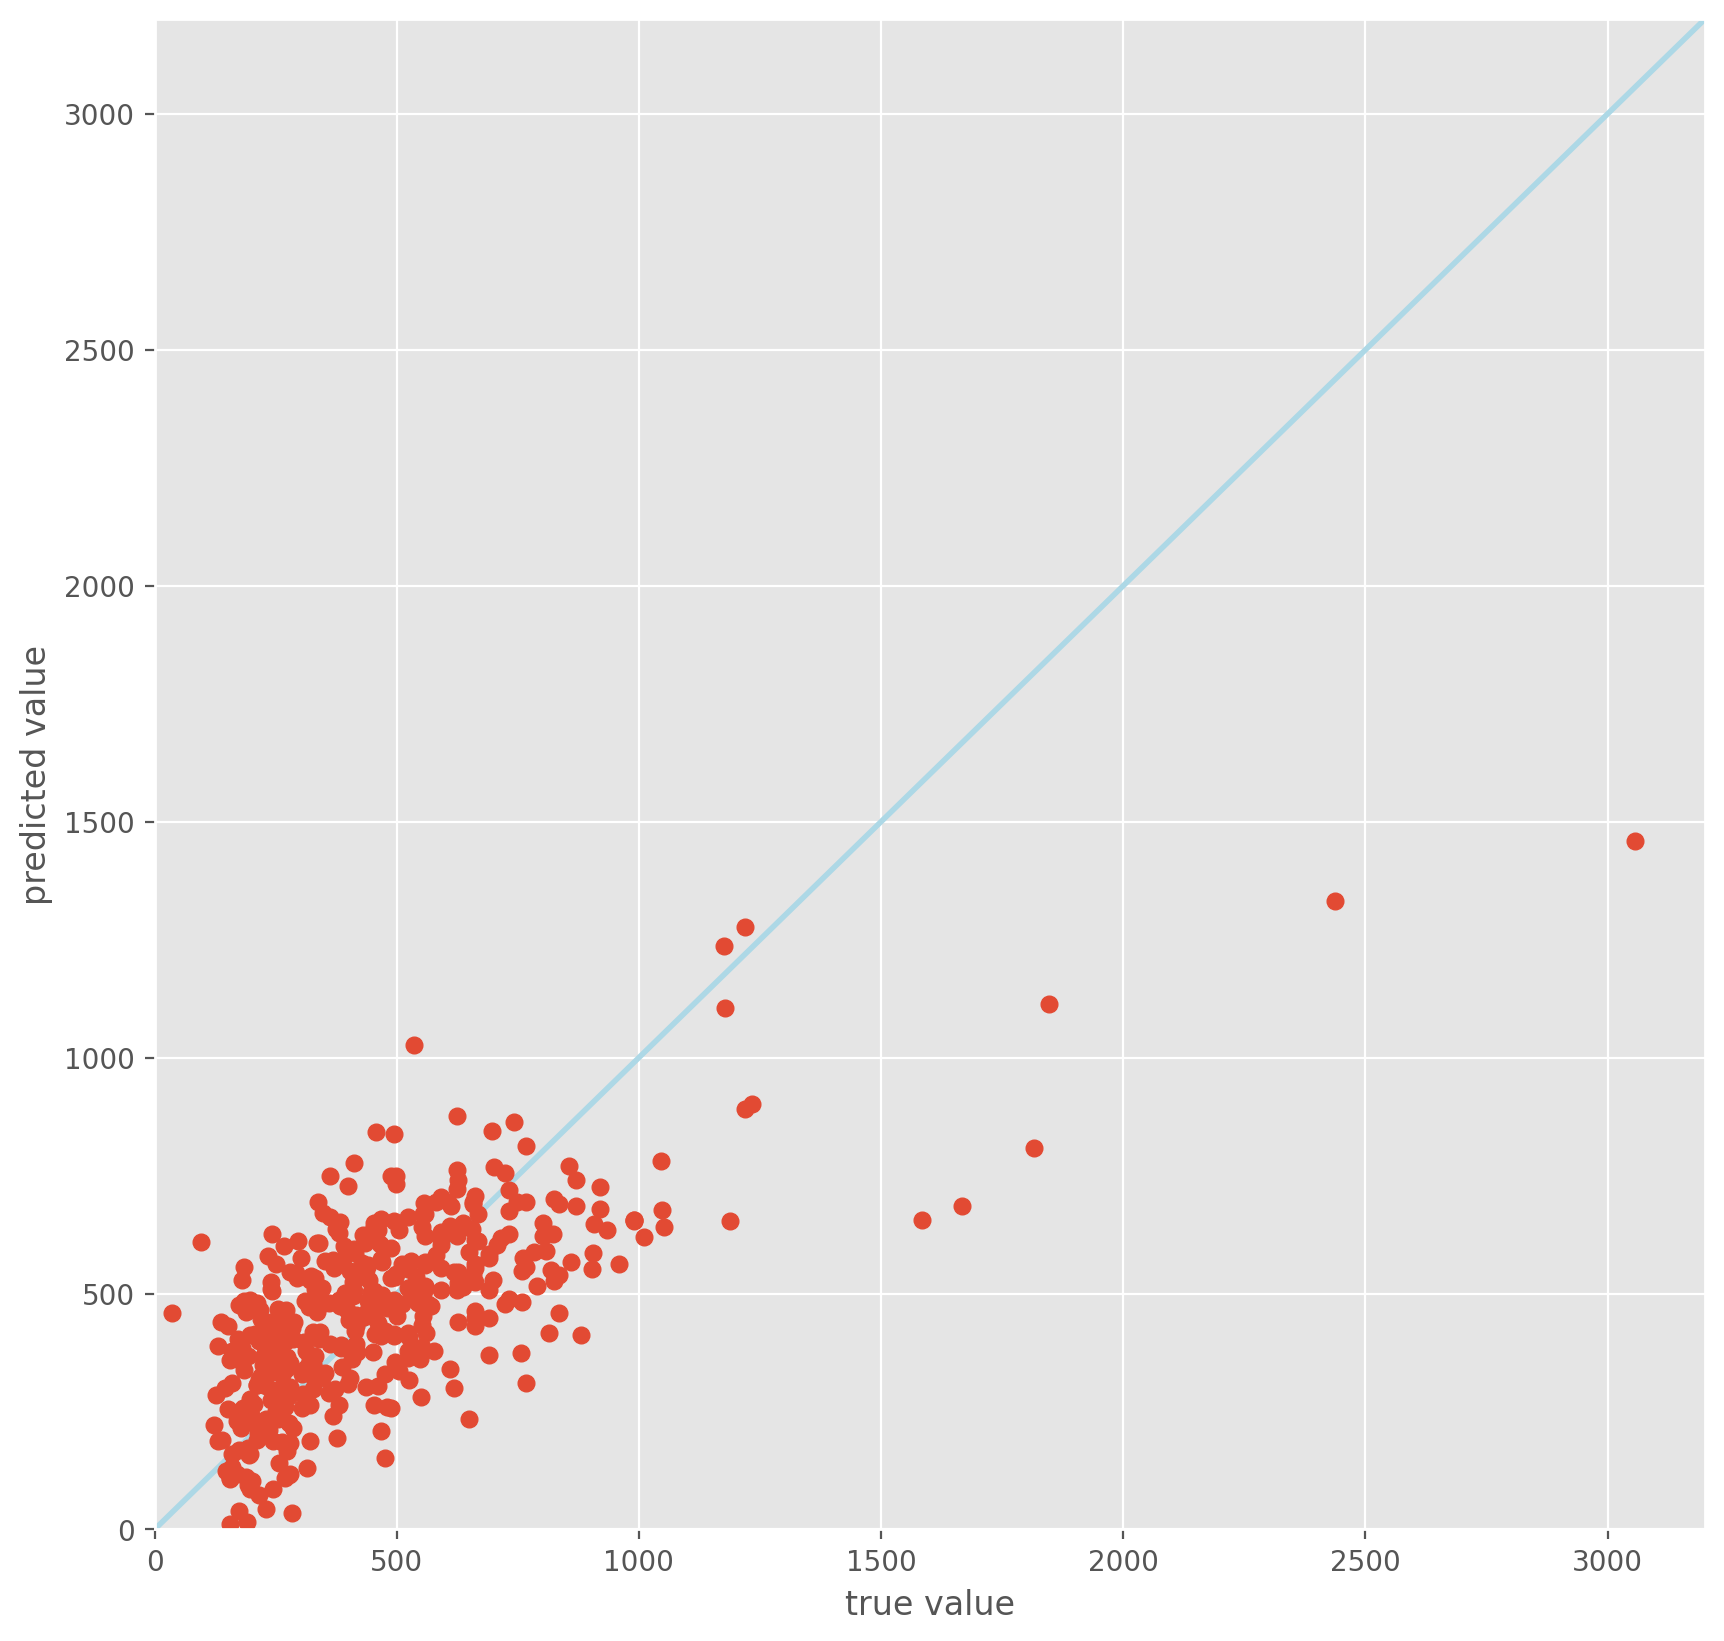

In [11]:
import numpy as np
#model = make_pipeline(DecisionTreeRegressor(max_depth=2))
model = make_pipeline(StandardScaler(), Ridge())
#model = LinearRegression(normalize=True)
#model = make_pipeline(StandardScaler(), KNeighborsRegressor())
#model = make_pipeline(StandardScaler(), SVR(kernel='linear'))
#model = make_pipeline(SVR(kernel='rbf', gamma='scale', C=10000))
#model = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden, max_iter=iters))
model.fit(X, y)
Y = model.predict(X)
maxx = 3200
xs = np.linspace(0, maxx, 2)
plt.figure(figsize=(10, 10))
plt.plot(xs, xs, lw=2, zorder=1, color='lightblue')
plt.scatter(y, Y, zorder=2, cmap='YlOrBr')
plt.xlim(0, maxx)
plt.ylim(0, maxx)
plt.xlabel('true value')
plt.ylabel('predicted value')
plt.show()

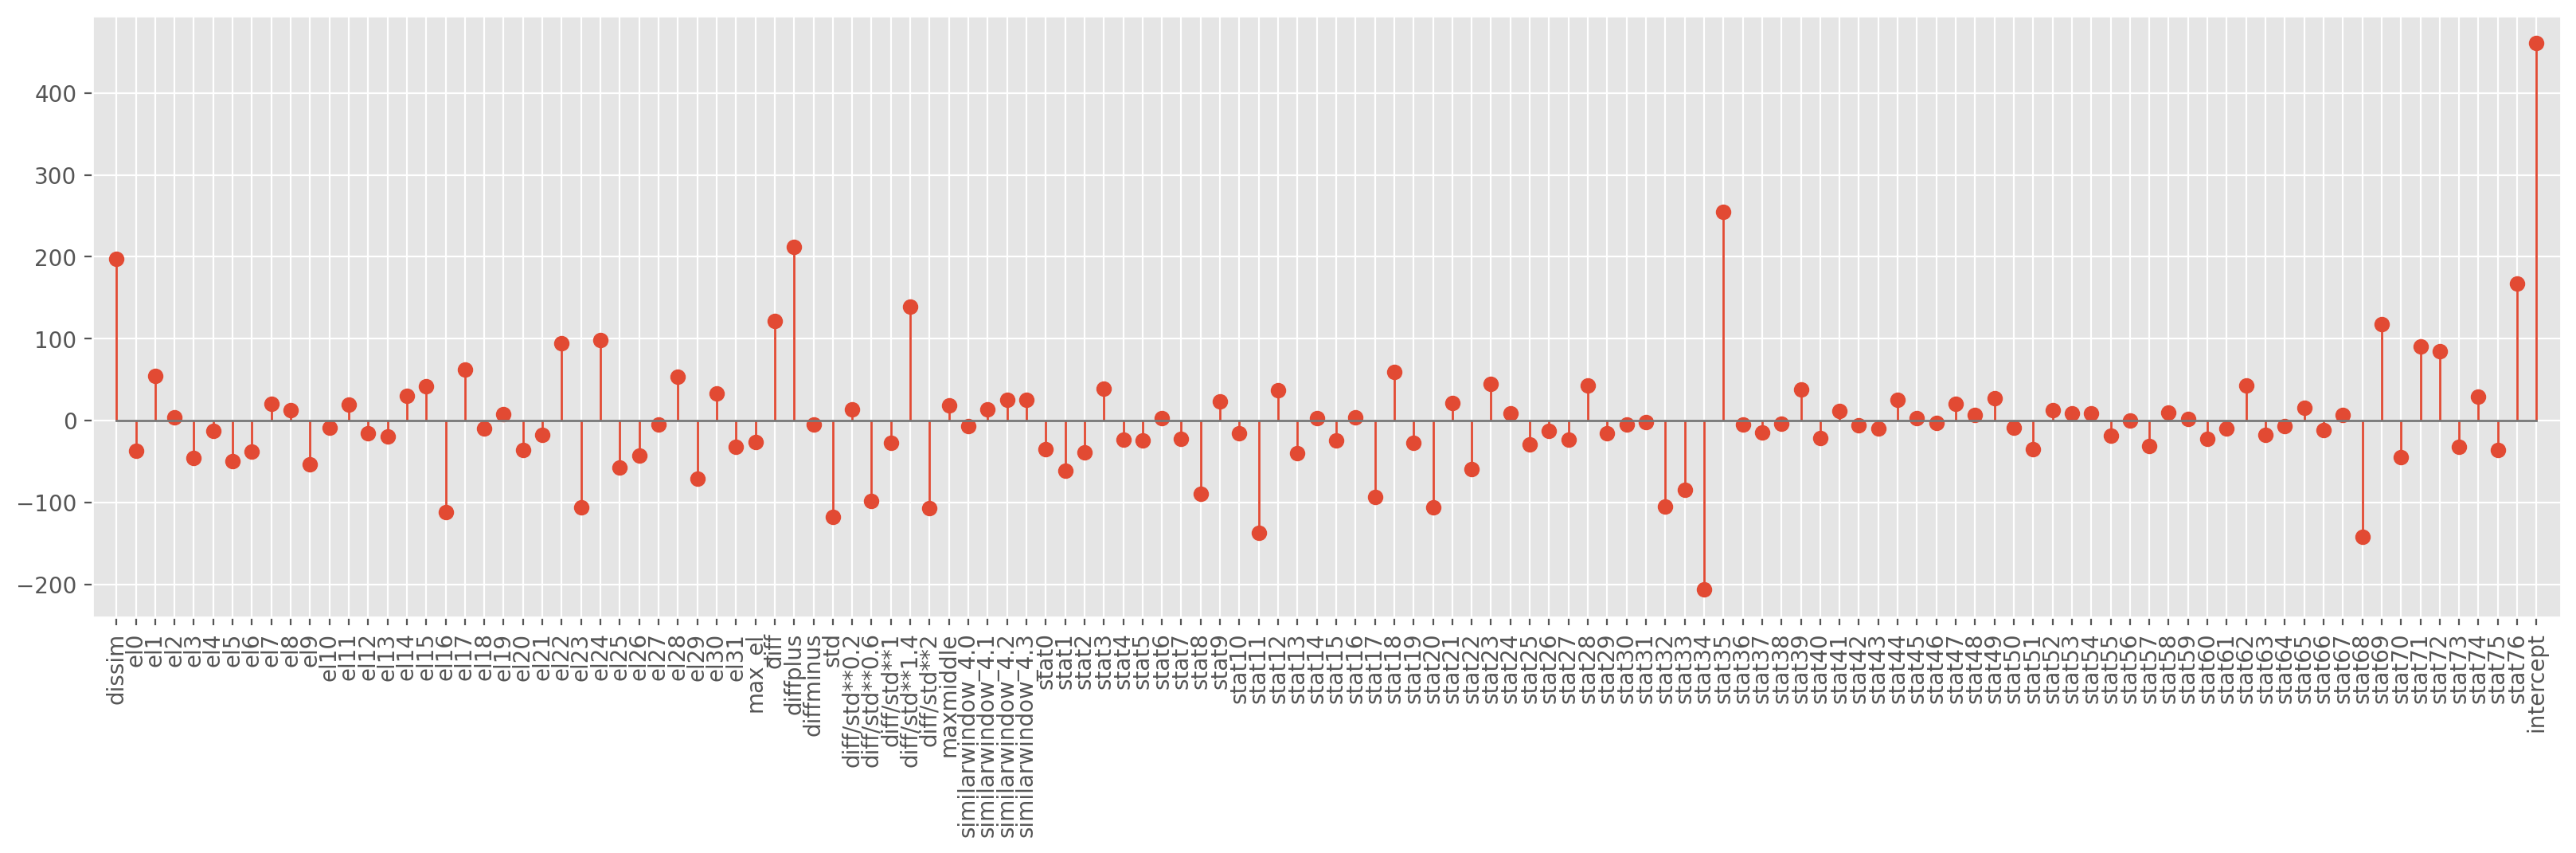

In [12]:
regr = model.named_steps['ridge']
plt.figure(figsize=(20, 5))
plt.stem(list(df.columns[:-1]) + ['intercept'], list(regr.coef_) + [regr.intercept_])
plt.xticks(rotation=90)
plt.margins(x=0.01)
plt.show()

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

models = dict(
    tree_unlimited=DecisionTreeRegressor(max_depth=None),
    tree_shallow=DecisionTreeRegressor(max_depth=2),
    linear=make_pipeline(StandardScaler(), LinearRegression()),
    ridge=make_pipeline(StandardScaler(), Ridge()),
    knn=make_pipeline(StandardScaler(), KNeighborsRegressor()),
    mlp=make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden, max_iter=iters)),
    svr_linear=make_pipeline(StandardScaler(), SVR(kernel='linear')),
    svr_rbf=make_pipeline(StandardScaler(), SVR(kernel='rbf')),
)

res = []
for model_name, model in models.items():
    cv = cross_validate(model, X, y, scoring=dict(MAE=make_scorer(MAE), MedAE=make_scorer(MedAE)), cv=10)
    res.append(dict(Model=model_name, MAE=np.mean(cv['test_MAE']), MedAE=np.mean(cv['test_MedAE'])))
res_test = pd.DataFrame(res)
res_test


,Model,MAE,MedAE
0,tree_unlimited,277.693030,172.525000
1,tree_shallow,213.111385,154.449163
2,linear,244.923124,184.067998
3,ridge,235.427275,184.164701
4,knn,220.877354,163.505000
5,mlp,279.252849,202.641199
6,svr_linear,191.369845,144.647236
7,svr_rbf,216.215129,170.910398


In [ ]:
res_test['MAE (total)'] = res_total.MAE
res_test['MedAE (total)'] = res_total.MedAE
res_test[['Model', 'MAE', 'MedAE', 'MAE (total)', 'MedAE (total)']].plot.bar(x='Model', color=['darkgreen', 'darkblue', 'green', 'blue'])
plt.title('')
plt.xticks(rotation=0)
plt.ylabel('Test Error')
plt.show()

In [14]:
res_test

,Model,MAE,MedAE
0,tree_unlimited,277.693030,172.525000
1,tree_shallow,213.111385,154.449163
2,linear,244.923124,184.067998
3,ridge,235.427275,184.164701
4,knn,220.877354,163.505000
5,mlp,279.252849,202.641199
6,svr_linear,191.369845,144.647236
7,svr_rbf,216.215129,170.910398
